In [1]:
import os
import time
import shutil

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import itertools

import matplotlib.pyplot as plt

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator #, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.convolutional import *
%matplotlib inline

Constants

In [2]:
SELF_PATH = os.getcwd()
PATH_TO_FILE_STREAM = 'G:\\Shared drives\\P-Sick'
PATH_TO_IMAGES = os.path.join(PATH_TO_FILE_STREAM, 'small\\Florence\\20180917a_jpgs\\jpgs')
PATH_TO_TAG_CSV = os.path.join(SELF_PATH, '../tagging_data.csv')

TEST_TO_TRAIN_RATIO = 0.3
VALIDATION_TO_TRAIN_RATIO = 0.3

TRAINING_IMAGE_FOLDER = "..\\_training_images"
TESTING_IMAGE_FOLDER = "..\\_testing_images"
VALIDATION_IMAGE_FOLDER = "..\\_validation_images"

IMPACT_CLASSES = ['0','1','2','3','4']

These are a list of the ids for impact
```
NoneId:0  
SwashId:1  
CollisionId:2  
OverwashId:3  
InundationId:4
```

# Getting the image data

1. We need to load the data from the csv
2. Split the images up into training and test set, and then place them in seperate folders.

First lets load the csv that has all the completely tagged image tags.

In [3]:
df_image_tags = pd.read_csv(PATH_TO_TAG_CSV)
df_impact_images = df_image_tags[['image_id','impact']]

# Creating the training,testing and validation sets

In [4]:
df_training_images, df_testing_images = train_test_split(df_impact_images, test_size=TEST_TO_TRAIN_RATIO, random_state=420)
df_training_images,df_validation_images = train_test_split(df_training_images, test_size=VALIDATION_TO_TRAIN_RATIO, random_state=1337)

Before we copy the images, remove all files within these folders

In [5]:
try:
    shutil.rmtree(TRAINING_IMAGE_FOLDER)
except:
    pass

try:
    shutil.rmtree(TESTING_IMAGE_FOLDER)
except:
    pass

try:
    shutil.rmtree(VALIDATION_IMAGE_FOLDER)
except:
    pass

Create the two training and test folders, and in each have a folder where the folder name is the impact type(0 to 4)

In [6]:
try:
    os.mkdir(TRAINING_IMAGE_FOLDER)
except:
  pass

try:
    os.mkdir(TESTING_IMAGE_FOLDER)
except:
  pass

try:
    os.mkdir(VALIDATION_IMAGE_FOLDER)
except:
  pass

In [7]:

for i in IMPACT_CLASSES:
    try:
         os.mkdir(os.path.join(TRAINING_IMAGE_FOLDER, f'{i}'))
    except:
        pass

    try:
         os.mkdir(os.path.join(TESTING_IMAGE_FOLDER, f'{i}'))
    except:
        pass
    
    try:
         os.mkdir(os.path.join(VALIDATION_IMAGE_FOLDER, f'{i}'))
    except:
        pass

Copy our training and test images into their respective folders, while keeping metadata with copy2

In [8]:
for index, row in df_training_images.iterrows():
    impact_path =  os.path.join(TRAINING_IMAGE_FOLDER,str(row['impact']))
    full_new_path =  os.path.join(impact_path,row['image_id'])
    shutil.copy2(os.path.join(PATH_TO_IMAGES,row['image_id']),  full_new_path)

for index, row in df_testing_images.iterrows():
    impact_path =  os.path.join(TESTING_IMAGE_FOLDER,str(row['impact']))
    full_new_path =  os.path.join(impact_path,row['image_id'])
    shutil.copy2(os.path.join(PATH_TO_IMAGES,row['image_id']),  full_new_path)

for index, row in df_validation_images.iterrows():
    impact_path =  os.path.join(VALIDATION_IMAGE_FOLDER,str(row['impact']))
    full_new_path =  os.path.join(impact_path,row['image_id'])
    shutil.copy2(os.path.join(PATH_TO_IMAGES,row['image_id']),  full_new_path)

# Preprocessing the images

1. For the training df, seperate the `image_id` and the `impact` into different np arrays for Keras

In [9]:
training_batch = ImageDataGenerator().flow_from_directory(TRAINING_IMAGE_FOLDER, target_size = (128,128), classes = IMPACT_CLASSES, batch_size = 10)
testing_batch = ImageDataGenerator().flow_from_directory(TESTING_IMAGE_FOLDER, target_size = (128,128), classes = IMPACT_CLASSES, batch_size = 10)
validation_batch = ImageDataGenerator().flow_from_directory(VALIDATION_IMAGE_FOLDER, target_size = (128,128), classes = IMPACT_CLASSES, batch_size = 4)

Found 121 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Found 52 images belonging to 5 classes.


In [10]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))

    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

C:\Users\skool\.virtualenvs\Poststorm_Imagery-AfucPPEW\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


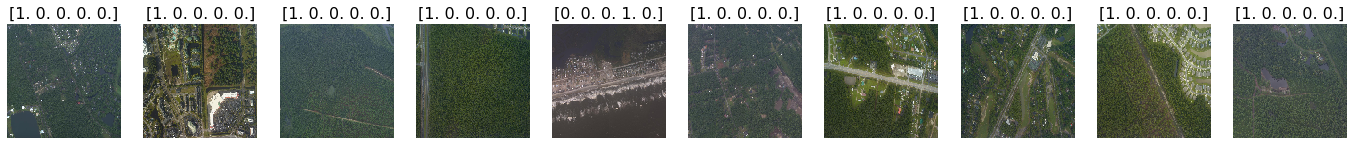

In [11]:
imgs, labels = next(training_batch)
plots(imgs,titles=labels,figsize=(24,6),rows = 1)

# Create Model

In [12]:
model = Sequential([
    Conv2D(32,(3,3),activation = 'relu', input_shape= (128,128,3)), #use 3 for 3rd parameters for rgb color
    Flatten(),
    Dense(len(IMPACT_CLASSES), activation = 'softmax')# use len of impact classes,cause thats how many classes we have
])

In [13]:
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics = ['accuracy'])

# Train and validate Model

In [14]:
# model.compile(Adam(lr=0.0001),loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# model.fit(image_samples,image_labels,batch_size = 5, epochs = 5, shuffle = True, verbose = 2, validation_split= TEST_TO_TRAIN_RATIO )
model.fit(training_batch, steps_per_epoch = 6, validation_data = validation_batch, validation_steps = 6, epochs = 10, verbose =2, )

Train for 6 steps, validate for 6 steps
Epoch 1/10
6/6 - 2s - loss: 275.3528 - accuracy: 0.3500 - val_loss: 234.8297 - val_accuracy: 0.7500
Epoch 2/10
6/6 - 1s - loss: 245.0990 - accuracy: 0.6863 - val_loss: 319.3178 - val_accuracy: 0.0833
Epoch 3/10
6/6 - 1s - loss: 259.2851 - accuracy: 0.2941 - val_loss: 130.4081 - val_accuracy: 0.7500
Epoch 4/10
6/6 - 1s - loss: 315.9053 - accuracy: 0.6000 - val_loss: 98.7510 - val_accuracy: 0.8750
Epoch 5/10
6/6 - 1s - loss: 167.0152 - accuracy: 0.5098 - val_loss: 86.5738 - val_accuracy: 0.6667
Epoch 6/10
6/6 - 1s - loss: 165.8622 - accuracy: 0.6078 - val_loss: 113.2385 - val_accuracy: 0.7500
Epoch 7/10
6/6 - 1s - loss: 88.8825 - accuracy: 0.6500 - val_loss: 88.3383 - val_accuracy: 0.7917
Epoch 8/10
6/6 - 1s - loss: 67.9166 - accuracy: 0.6833 - val_loss: 40.3879 - val_accuracy: 0.8333
Epoch 9/10
6/6 - 1s - loss: 31.3119 - accuracy: 0.7833 - val_loss: 44.6577 - val_accuracy: 0.8750
Epoch 10/10
6/6 - 1s - loss: 24.0516 - accuracy: 0.7647 - val_loss: 

# Predicting on test set

C:\Users\skool\.virtualenvs\Poststorm_Imagery-AfucPPEW\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


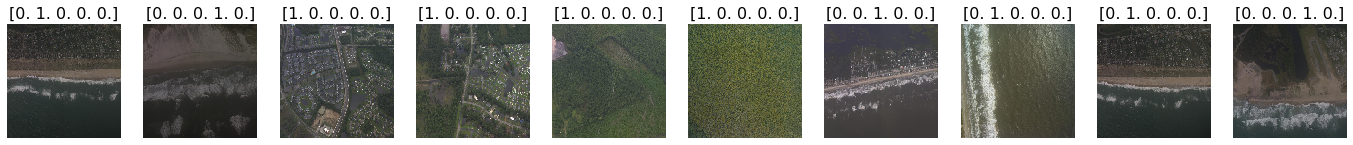

In [15]:
test_imgs, test_labels = next(testing_batch)
plots(test_imgs,titles=test_labels,figsize=(24,6),rows = 1)

In [46]:
predictions = model.predict_generator(testing_batch, steps = 1, verbose = 2)
for i in predictions:
    rounded = [round(x) for x in i]
    print(rounded)

1/1 - 0s
[0.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0]


In [44]:
for i in test_labels:
    rounded = [round(x) for x in i]
    print(rounded)

[0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0]


In [41]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
